In [151]:
from transformers import pipeline
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import numpy as np
from main import inference

In [152]:
checkpoint = "google/owlvit-base-patch16"
# checkpoint = "google/owlvit-large-patch14"
# checkpoint = "google/owlv2-base-patch16-ensemble"
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

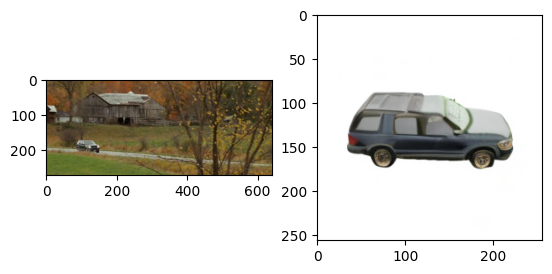

In [219]:
# query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/230_white.jpg")
# query_image = query_image.convert('RGB')
# query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/00000230.jpg")
query_image = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/classification/data/train/car/8_495.png")
query_image = query_image.convert('RGB')
image_target = Image.open(r"/projects/academic/rohini/m44/git-prjs/3DVision/Mach/data/00000120.jpg")

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)

In [ ]:
def make_square(image, desired_size=640):
    h, w, _ = image.shape
    padding_y = max(0, (desired_size - h) // 2)

    # Create a new square canvas filled with zeros (black)
    square_image = np.zeros((desired_size, desired_size, 3), dtype=np.uint8)

    # Place the original image in the center
    square_image[padding_y:padding_y + h, :, :] = image

    return square_image

# make image square
image_target = np.array(image_target)
image_target = make_square(image_target)
image_target = Image.fromarray(image_target)
image_target


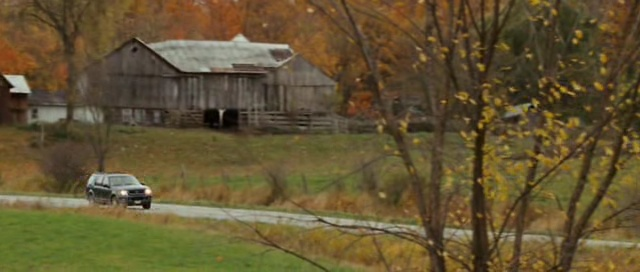

In [221]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")
from copy import deepcopy
test_img = deepcopy(image_target)
test_img

253.11676025390625 52.532657623291016 356.2770080566406 126.92192840576172
4.570331573486328 0.28339385986328125 641.144287109375 271.58074951171875
81.89085388183594 172.46766662597656 154.65213012695312 209.65159606933594
221.29058837890625 138.40809631347656 459.8899841308594 203.41329956054688
0.9537696838378906 202.42901611328125 390.80145263671875 274.9360656738281


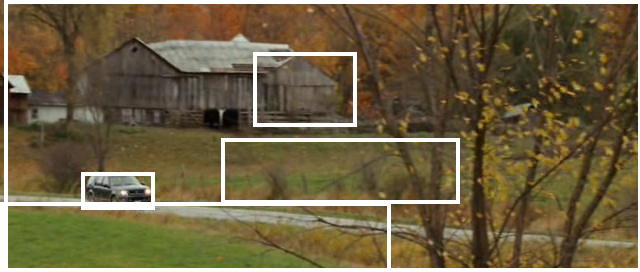

In [223]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.05, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)
    print(xmin,ymin,xmax,ymax)

image_target

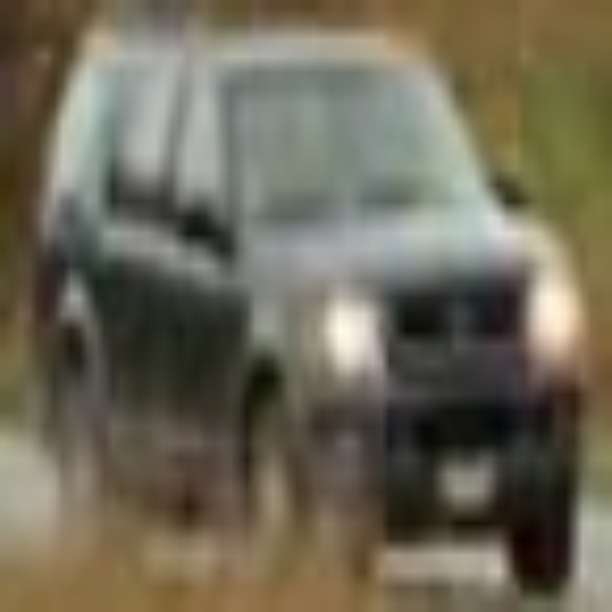

In [226]:
from torchvision import transforms
resize_transform = transforms.Resize((612,612))
img = test_img.crop((81.89085388183594,172.46766662597656,154.65213012695312,209.65159606933594))
output = resize_transform(img)
output

In [227]:
from main import  infer_single_image
from copy import deepcopy

In [228]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.05, target_sizes=target_sizes)[0]

# draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

predictions = []
crops = []

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    # get the crop of  this box to feed to the model
    temp_img = deepcopy(image_target)
    crop = temp_img.crop((xmin, ymin, xmax, ymax))
    # check bounding box's aspect ratio and reject if too weird
    # get the prediction of the crop
    crops.append(crop)
    prediction = infer_single_image(crop)
    predictions.append(prediction[0])
    

Loaded scheduler state from checkpoint.
Loaded checkpoint from: ./checkpoints/checkpoint.pth
Loaded scheduler state from checkpoint.
Loaded checkpoint from: ./checkpoints/checkpoint.pth
Loaded scheduler state from checkpoint.
Loaded checkpoint from: ./checkpoints/checkpoint.pth
Loaded scheduler state from checkpoint.
Loaded checkpoint from: ./checkpoints/checkpoint.pth
Loaded scheduler state from checkpoint.
Loaded checkpoint from: ./checkpoints/checkpoint.pth


In [229]:
print(predictions)
predictions = np.array(predictions)

[0, 0, 0, 0, 0]


In [115]:
positive_indices = np.where(predictions > 0)[0].tolist()

In [119]:
crops[positive_indices[3]]